In [54]:
# Library that uses youtube's API to scrape youtube videos
!pip install pytube3

In [1]:
# Combs through various ASL websites and downloads mp4 videos for desired words
# Current websites:
#    - handspeak.com
#    - signingsavvy.com
#    - startasl.com
#    - signasl.org
#    - asldeafined.com
#    - asl-lex.org
#    - aslpro.com
#    - aslsearch.com
#    - http://commtechlab.msu.edu/sites/aslweb
#    - smartsign
#
# More difficult to scrape from:
#    - lifeprint.com - naming scheme is super inconsistent
#.   - signingonline.com - requires enrollment/trial account
#.   - aslteachingresources.com - videos have a lot of fluff on them, some are super off center
#.   - signwithme.com - vids are low quality gifs, not a lot of words
#.   - https://vl2.educ.ualberta.ca/find-a-sign - only has 300 signs, hard to scrape
#.   - https://www.signschool.com/tools/dictionary/all/
#.   - signlanguage student

from bs4 import BeautifulSoup as bs
import requests
import urllib.request as req
import time
import os
import numpy as np
import pandas as pd
import pickle as pk

from utils import download_video

from pytube import YouTube
from pytube.exceptions import RegexMatchError
    
#from cv_utils import *
rootDir = '/data/ASL/'

# Words to scrape from websites
# lexicon = ['boy', 'girl', 'cat', 'dog', 'family', 'baby', 'home', 'tree']
lexicon = ['dog', 'cat', 'cow', 'rabbit', 'duck', 'chicken', 'horse', 
           'squirrel', 'pig', 'turkey', 'donkey', 'goat', 'mouse', 
           'deer', 'wolf', 'bear', 'lion', 'tiger', 'snake', 'bird', 'turtle', 'octopus',
           'frog', 'whale', 'shark', 'crab', 'fish', 'lobster', 'alligator', 'camel', 'fox', 
           'elephant', 'ostrich', 'seal', 'penguin']

lexicon = list(set(lexicon))
lexicon = [word.lower() for word in lexicon]
lexicon.sort()
dict_of_urls = {}
for word in lexicon:
    dict_of_urls[word] = []


In [2]:
# scrape videos from handspeak.com
url_lookup_path = 'csv_files/handspeak_urls.pckl'
if os.path.exists(url_lookup_path):
    with open(url_lookup_path, 'rb') as f:
        handspeak_urls = pk.load(f)
else:
    print(">> Didn't find an existing url lookup path. Creating one now (this will take a few mins)")
    handspeak_metadata = {}
    ts = time.time()
    duplicates = {}
    for i in range(1, 8685):
        url = "https://www.handspeak.com/word/search/index.php?id={}".format(i)
        soup = bs(req.urlopen(url).read(), 'html.parser')
        #soup_text = soup.text
        vid_tag = soup.find("video", id="mySign")
        vid_url = "http://handspeak.com"+vid_tag['src']
        word = vid_tag['title'].split(sep="ASL sign for ")[1]
        word = word.lower()

        avg_time_per_site = (time.time()-ts)/(i+1)
        time_remaining = 8685*avg_time_per_site - (time.time()-ts)
        print("{}. ({:.1f} mins remaining) Found link for {}: {}".format(i, time_remaining/60, word, vid_url), end="\r")
        if word not in handspeak_metadata:
            handspeak_metadata[word] = vid_url
    print('\n >> Done. Took {:.2f} mins'.format((time.time()-ts)/60))
    with open(url_lookup_path, 'wb') as f:
        pk.dump(handspeak_metadata, f)
    print('>> Saved url lookup table to: {}'.format(url_lookup_path))

num_urls = 0
num_invalid = 0
for word in lexicon:
    if word in handspeak_urls:
        vid_url = handspeak_urls[word]
        if vid_url not in dict_of_urls[word]:
            dict_of_urls[word].append(vid_url)
            num_urls += 1
    else:
        print('>> WARNING: Could not find word {} in handspeak_urls!'.format(word))
        num_invalid += 1
print('Found {} urls from handspeak. Was unable to find videos for {} words.'.format(num_urls, num_invalid))
    

>> ERROR: Could not find word seal in handspeak_urls!
Found 34 urls from handspeak. Was unable to find videos for 1 words.


In [3]:
# scrape videos from signingsavvy.com
base_url = "https://www.signingsavvy.com"

num_urls = 0
for word in lexicon:
    first_letter = word[0]
    url = os.path.join(base_url, 'browse/{}'.format(first_letter))
    soup = bs(req.urlopen(url).read(), 'html.parser')
    search_request = soup.find('div', class_='search_results').ul
    for word_tag in search_request.find_all(name="li"):
        word_tag_str = word_tag.a.text.lower()
        if word_tag_str == word:
            url = os.path.join(base_url, word_tag.a["href"])
            soup = bs(req.urlopen(url).read(), 'html.parser')
            vid_tag = soup.find(name='video')
            vid_url = os.path.join(base_url, vid_tag.source['src'])
            
            if vid_url not in dict_of_urls[word]:
                dict_of_urls[word].append(vid_url)
                num_urls += 1
print('Found {} videos from signingsavvy.com'.format(num_urls))

Found 41 videos from signingsavvy.com


In [111]:
# scrape videos from startasl.com
num_urls = 0
for p in np.arange(60):
    url = "https://courses.startasl.com/mod/glossary/view.php?id=463&mode=letter&hook=ALL&sortkey&sortorder=asc&fullsearch=0&page="+str(p)         
    sauce = req.urlopen(url).read()
    soup = bs(sauce, 'html.parser')
    
    for entry_tag in soup.find_all(name="td", class_="entry"):
        word_tag = entry_tag.find(name="div", class_="concept")
        word = word_tag.text.lower()
        if len(entry_tag.find_all(name="a", class_="mediafallbacklink")) > 0:
            if word in lexicon:
                vid_tag = entry_tag.find(name="a", class_="mediafallbacklink")
                vid_url = vid_tag['href']
                
                # Download video
                if vid_url not in dict_of_urls[word]:
                    dict_of_urls[word].append(vid_url)
                    num_urls += 1
print('Found {} videos from startasl.com'.format(num_urls))

Found 8 videos from startasl.com


In [112]:
# scrape videos from signasl.org
# Just collect all video urls on first pass. Then can download them in separate loop
# Reason for this is sometimes youtube gets mad at blocks my ip from spam downloading :( )
base_url = "https://www.signasl.org/sign/{}"

num_urls = 0
for word in lexicon:
    
    url = base_url.format(word)
    url_request = req.Request(url, headers={'User-agent': 'Mozilla/5.0'})
    soup = bs(req.urlopen(url_request).read(), 'html.parser')

    for vid_chunk in soup.find_all(name="div", itemprop="video"):
        
        # Check that word is in caption
        caption = vid_chunk.div.i.text.lower()
        if word != caption:
            continue
        
        for meta in vid_chunk.find_all(name="meta"):
            
            # Skip if you already saved this url (to handle duplicate urls that appear)
            vid_url = meta['content']
            if vid_url in dict_of_urls[word]:
                continue
            
            if word+'.mp4' in vid_url:
                
                dict_of_urls[word].append(vid_url)
                num_urls +=1
            
            elif "www.youtube.com/watch" in vid_url:
                try:
                    yt = YouTube(vid_url)
                except RegexMatchError:
                    print('>> Encountered invalid youtube link: {}'.format(vid_url))
                    continue
                
                if word in yt.title.lower():
                    
                    dict_of_urls[word].append(vid_url)
                    time.sleep(10) # Go super slowly so youtube doesn't yell at me
                    num_urls +=1

print('Found a total of {} videos from signasl'.format(num_urls))


>> Encountered invalid youtube link: https://www.youtube.com/watch?v=wOX5axCecY4
>> Encountered invalid youtube link: https://www.youtube.com/watch?v=wOX5axCecY4
>> Encountered invalid youtube link: https://www.youtube.com/watch?v=6lqC6aDUTOc
>> Encountered invalid youtube link: https://www.youtube.com/watch?v=6lqC6aDUTOc
Found a total of 38 videos from signasl


In [113]:
# scrape videos from asldeafined.com
base_url = 'https://www.asldeafined.com/internal/dictionary-search/?word={}'

num_urls = 0
for word in lexicon:
    search_url = base_url.format(word)
    sauce = req.urlopen(search_url).read()
    soup = bs(sauce, 'html.parser')
    dict_tag = soup.find('div', id='dictionary-index')
    for word_tag in dict_tag.find_all(name="a"):
        
        # Remove all non-letters from scraped word
        scraped_word = word_tag.text.lower()
        cleaned_word = ''.join(filter(str.isalpha, scraped_word))
        if cleaned_word == word:
            vid_url = word_tag['video-url']
            if not vid_url.endswith('.mp4'):
                print('>> Found a non-mp4 video: {}'.format(vid_url))
            else:
                if vid_url not in dict_of_urls[word]:
                    dict_of_urls[word].append(vid_url)
                    num_urls += 1
                    
print("Found {} videos from asldeafined".format(num_urls))
    

Found 18 videos from asldeafined


In [115]:
# scrape from asl-lex
# This one is a bit different - have to look up youtube vid in the csv
df = pd.read_csv('csv_files/asl-lex.csv')
list_of_headers = df.columns
all_lemmas = list(df['LemmaID'].values)
all_lemmas_cleaned = [word.lower() for word in all_lemmas]

num_urls = 0
for word in lexicon:
    
    # Collect all youtube vid urls for given word
    word_lookup = df[df['LemmaID'] == word]
    youtube_urls = []
    for yt_html in word_lookup['YouTube Video']:
        #<iframe width="280" height="158" src="https://www.youtube.com/embed/ys0QCfNZWZc?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>
        youtube_url = yt_html.split(sep='src="')[-1]
        youtube_url = youtube_url.split(sep="?")[0]
        if vid_url not in dict_of_urls[word]:
            dict_of_urls[word].append(youtube_url)
            num_urls += 1
    
print("Found {} youtube vids from asl-lex".format(num_urls))

Found 9 youtube vids from asl-lex


In [116]:
# Scrape from aslpro.com
base_url = 'http://www.aslpro.cc/main/{}/{}.mp4'

num_urls = 0
for word in lexicon:
    vid_url = base_url.format(word[0], word)
    if vid_url not in dict_of_urls[word]:
        dict_of_urls[word].append(vid_url)
        num_urls += 1
print('Found {} urls from aslpro.com'.format(num_urls))



Found 8 urls from aslpro.com


In [117]:
# Scrape from aslsearch.com
base_url = 'http://aslsearch.com/'
print('>> Loading entire search directory from aslsearch.com (this may take a few seconds)')
main_search_url = "http://aslsearch.com/search-result.php"
sauce = req.urlopen(main_search_url).read()
soup = bs(sauce, 'html.parser')
all_search_results_tag = soup.find("div", id="content")
i = 0
num_urls = 0
for word_tag in all_search_results_tag.find_all("a"):
    if word_tag['href'] == '#top': continue
    search_word = word_tag.strong.text.lower()
    search_php = word_tag['href']
    search_url = base_url + search_php
    if search_word in lexicon:

        # If webpage for a word is found, scrape that page for mp4
        sauce = req.urlopen(search_url).read()
        soup = bs(sauce, 'html.parser')
        for media_tag in soup.find_all('div', id="mediaplayer"):
            media_tag_str = (media_tag.script.text).split(sep=' file: "')[1]
            media_tag_str = media_tag_str.split(sep=".mp4")[0]+".mp4"
            vid_url = base_url + media_tag_str
            
            if vid_url not in dict_of_urls[word]:
                dict_of_urls[word].append(vid_url)
                num_urls += 1
        i += 1
print('Found {} videos on aslsearch.com'.format(num_urls))


>> Loading entire search directory from aslsearch.com (this may take a few seconds)
Found 8 videos on aslsearch.com


In [118]:
# Scrape commtechlab.msu.edu/sites/aslweb/browser.htm
base_letter_url = "http://commtechlab.msu.edu/sites/aslweb/{}/index.htm"
base_vid_url = "http://commtechlab.msu.edu/sites/aslweb/"

num_urls = 0
for ci in range(65, 65+26):
    letter = chr(ci)
    letter_url = base_letter_url.format(letter)
    sauce = req.urlopen(letter_url).read()
    soup = bs(sauce, 'html.parser')
    for word_tag in soup.html.body.find_all("a", target="word"):
        found_word = word_tag.text.lower()
        if found_word in lexicon:
            url_end = word_tag["href"]
            word_url = 'http://commtechlab.msu.edu/sites/aslweb/{}/{}'.format(letter, url_end)
            
            
            word_sauce = req.urlopen(word_url).read()
            word_soup = bs(word_sauce, 'html.parser')
            
            vid_url_ending = word_soup.embed['src'].split(sep="../")[1]
            vid_url = base_vid_url + vid_url_ending
            
            if vid_url not in dict_of_urls[word]:
                dict_of_urls[word].append(vid_url)
                num_urls += 1
print("Found {} videos on aslweb".format(num_urls))

Found 8 videos on aslweb


In [119]:
# Scrape from signschool.com
# Not done yet - a lof of javascript witchcraft going on here
#print('>> Loading entire search directory from signschool.com (this may take a few seconds)')
#main_search_url = 'https://www.signschool.com/tools/dictionary/all/'
#sauce = req.urlopen(main_search_url).read()
#soup = bs(sauce, 'html.parser')
#all_search_results_tag = soup.find("div", id="content")
#print(soup.prettify())

In [120]:
# Scrape from smartsign
# Have to manually parse a fat javascript string
js_url = "http://storage.googleapis.com/smartsigndictionary.org/js/setthumbs{}.js"

num_urls = 0
for ci in range(66, 65+26):
    letter = chr(ci)
    letter_url = js_url.format(letter)
    sauce = req.urlopen(letter_url).read()
    soup = bs(sauce, 'html.parser')
    soup_text = soup.text
    
    # Get all words in lexicon starting with this letter
    words_with_letter = [i for i in lexicon if i[0].lower() == letter.lower()]
    for word in words_with_letter:
        delimiter = '(currentWord == "{}") ytid1= "'.format(word)
        after = soup_text.split(sep=delimiter)[1]
        youtube_end = after.split(sep='";')[0]
        vid_url = 'http://youtube.com/watch?v='+youtube_end
        if vid_url not in dict_of_urls[word]:
            dict_of_urls[word].append(vid_url)
            num_urls += 1
print('Found {} videos on smartsign'.format(num_urls))

Found 8 videos on smartsign


In [121]:
# spreadthesign.com
base_url = "https://www.spreadthesign.com/en.us/search/?q={}"

num_urls = 0
for word in lexicon:
    search_url = base_url.format(word)
    sauce = req.urlopen(search_url).read()
    soup = bs(sauce, 'html.parser')
    for word_tag in soup.find_all("div", class_="search-result-title"):
        found_word = word_tag.a.find(text=True).strip().lower()
        url = 'http://spreadthesign.com'+word_tag.a['href']
        
        # Open search result that is exact match to lexicon word
        if found_word == word:
            word_soup = bs(req.urlopen(url).read(), 'html.parser')
            try:
                video_tag = word_soup.find("video")
                vid_url = video_tag['src']
            except:
                print('Couldnt find video for word {}'.format(word))
                continue
            
            if vid_url not in dict_of_urls[word]:
                dict_of_urls[word].append(vid_url)
            num_urls += 1
print('Found {} videos on spreadthesign.com'.format(num_urls))


Found 8 videos on spreadthesign.com


In [122]:
# scrape videos from signschool.com

url_lookup_path = 'csv_files/signschool_urls.pckl'
if os.path.exists(url_lookup_path):
    with open(url_lookup_path, 'rb') as f:
        signschool_urls = pk.load(f)
else:
    print(">> Didn't find an existing url lookup path. Creating one now (this will take a few mins)")
    signschool_metadata = {}
    ts = time.time()
    duplicates = {}
    for i in range(1, 6661):
        url = "https://www.signschool.com/terms/signs/{}".format(i)
        try:
            soup = bs(req.urlopen(url).read(), 'html.parser')
            word_tag = soup.find("h1")
            word = word_tag.text.strip().lower()
            vid_url = soup.find("source")['src']
        except:
            print("")
            print('Couldnt find valid video for index {}, skipping'.format(i))
            continue
        
        avg_time_per_site = (time.time()-ts)/(i+1)
        time_remaining = 8685*avg_time_per_site - (time.time()-ts)
        print("{}. ({:.1f} mins remaining) Found link for {}: {}".format(i, time_remaining/60, word, vid_url), end="\r")
        if word not in signschool_metadata:
            signschool_metadata[word] = vid_url
    print('\n >> Done. Took {:.2f} mins'.format((time.time()-ts)/60))
    with open(url_lookup_path, 'wb') as f:
        pk.dump(signschool_metadata, f)
    print('>> Saved url lookup table to: {}'.format(url_lookup_path))

num_urls = 0
num_invalid = 0
for word in lexicon:
    
    if word in signschool_urls:
        vid_url = signschool_urls[word]
        if vid_url not in dict_of_urls[word]:
            dict_of_urls[word].append(vid_url)
            num_urls += 1
    else:
        print('>> ERROR: Could not find word {} in signschool_urls!'.format(word))
        num_invalid += 1
print('Found {} urls from signschool. Was unable to find videos for {} words.'.format(num_urls, num_invalid))
    

Found 8 urls from signschool. Was unable to find videos for 0 words.


In [123]:
# Directory to save raw data to
# Layout of data directory will look like:
# rootDir
#     word1
#         - 1_websitename.mp4
#         - 2_websitename.mp4
#     word2
#         - 1_websitename.mp4
#         - 2_websitename.mp4

# Directory to save training vids

if not os.path.exists(rootDir):
    os.mkdir(rootDir)

if not os.path.exists(rootDir):
    os.mkdir(rootDir)
for word in lexicon:
    subDir = os.path.join(rootDir, word)
    if not os.path.exists(subDir):
        os.mkdir(subDir)
        
downloaded_urls = []

NameError: name 'stop' is not defined

In [126]:
num_downloaded = 0
for word, urls in dict_of_urls.items():
    sub_dir = os.path.join(rootDir, word)
    for url in urls:
        if url in downloaded_urls:
            continue
        if url.endswith(".mp4"):
            save_name = str(len(os.listdir(sub_dir))+1) + '.mp4'
            save_path = os.path.join(sub_dir, save_name)
            download_video(url, save_path)
            downloaded_urls.append(url)
            print('({}) Saving video for {} to: {}'.format(num_downloaded, word, save_path))
            num_downloaded += 1
        elif "youtube.com" in url:
            yt = YouTube(url)
            vid_file = yt.streams.filter(file_extension='mp4').first()
            save_name = str(len(os.listdir(sub_dir))+1)
            vid_file.download(output_path=sub_dir, filename=save_name)
            downloaded_urls.append(url)
            print('({}) Saving yt video for {} to: {}'.format(num_downloaded, word, os.path.join(sub_dir, save_name)))
            num_downloaded += 1
            time.sleep(10.1)
        else:
            print('>> ERROR: Unknown video url detected: {}'.format(url))
print('Downloaded {} total videos'.format(num_downloaded))

(0) Saving video for baby to: /data/ASL/baby/1.mp4
(1) Saving video for baby to: /data/ASL/baby/2.mp4
(2) Saving video for baby to: /data/ASL/baby/3.mp4
(3) Saving video for baby to: /data/ASL/baby/4.mp4
(4) Saving yt video for baby to: /data/ASL/baby/5
(5) Saving yt video for baby to: /data/ASL/baby/6
(6) Saving yt video for baby to: /data/ASL/baby/7
(7) Saving yt video for baby to: /data/ASL/baby/8
(8) Saving video for baby to: /data/ASL/baby/9.mp4
(9) Saving video for baby to: /data/ASL/baby/10.mp4
(10) Saving yt video for baby to: /data/ASL/baby/11
(11) Saving video for baby to: /data/ASL/baby/12.mp4
(12) Saving yt video for baby to: /data/ASL/baby/13
(13) Saving video for baby to: /data/ASL/baby/14.mp4
(14) Saving video for baby to: /data/ASL/baby/15.mp4
(15) Saving video for boy to: /data/ASL/boy/1.mp4
(16) Saving video for boy to: /data/ASL/boy/2.mp4
(17) Saving video for boy to: /data/ASL/boy/3.mp4
(18) Saving video for boy to: /data/ASL/boy/4.mp4
(19) Saving yt video for boy t

In [127]:
# Clean up videos that are invalid
from utils import *

for root, subdir, files in os.walk(rootDir):
    for file in files:
        #print(root)
        filepath = os.path.join(root, file)
        if file.endswith('.mp4'):
            vid_array = vid_to_array(filepath)
            if vid_array.shape == (0, 0, 0, 0):
                print('>> Invalid file found, deleting: {}'.format(filepath))
                os.remove(filepath)

(3, 83, 400, 720)


<IPython.core.display.Javascript object>


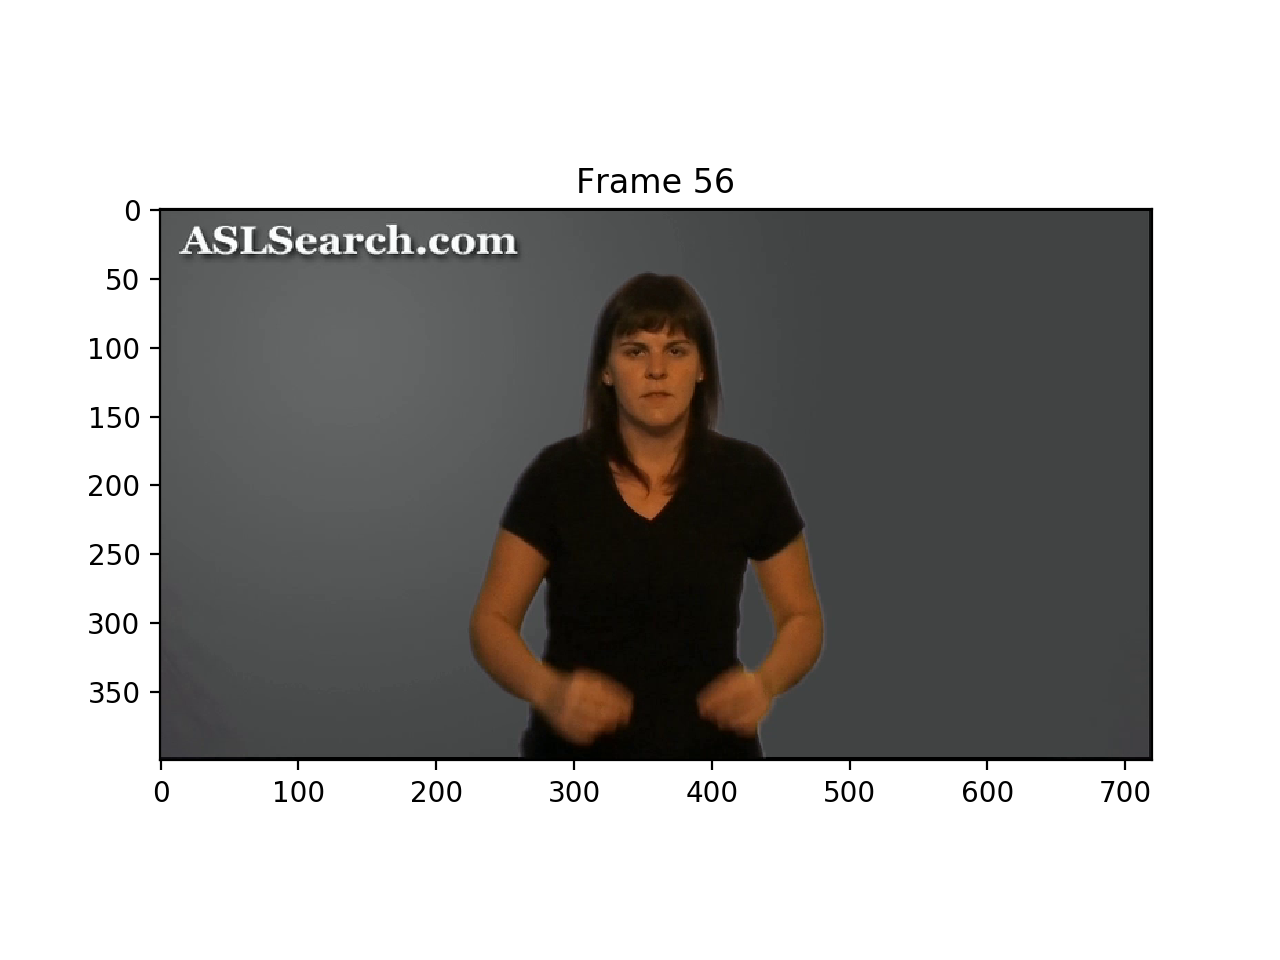

In [134]:
# Check that vids saved correctly
vid = vid_to_array('/data/ASL/tree/12.mp4')
print(vid.shape)
%matplotlib notebook
animate_movie(vid)